# GloFAS - Attributes from static maps and model parameters
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 14-10-2024<br>

**Introduction:**<br>
This notebook creates the static attributes for the catchmens of the reservoirs in the ResOpsUS dataset.

**To do:**<br>

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from tqdm.notebook import tqdm
from datetime import datetime
from shapely.geometry import Point
import yaml

from lisfloodreservoirs.utils.plots import plot_attributes

import sys
sys.path.append('../../../lisflood-utilities/src')
from lisfloodutilities.catchstats import catchment_statistics

## Configuration

In [43]:
# load config file
with open('attributes_from_static_maps.yml') as config_file:
    cfg = yaml.safe_load(config_file)

# path to the dataset
PATH_DATASET = Path(cfg['catchments']['path'])

# list of catchments
CATCH_FILE = cfg['catchments']['IDs']

# name of mask files
MASK_FILE = cfg['catchments']['mask_file']

# path to the static maps
PATH_MAPS = Path(cfg['static_maps']['path'])

# output
ID_OUT = cfg['output']['identifier']
PATH_OUT = Path(cfg['output']['path'])
PATH_PLOTS = PATH_OUT / 'plots'
PATH_PLOTS.mkdir(parents=False, exist_ok=True)
attributes = {}

## Base information

### Catchments

In [3]:
# load TXT used as input for `cutmaps`
catchments = pd.read_csv(PATH_DATASET / CATCH_FILE, sep='\t', header=None)#.squeeze()
catchments.columns = ['lon_orig', 'lat_orig', 'ID']
catchments.set_index('ID', drop=True, inplace=True)
catchments[['LON', 'LAT', 'CATCH_SKM']] = np.nan

###  Masks

The coordinates of the _my_mask.nc_ maps and those of the GloFAS static maps do not match at the nth decimal, so I have to recreate the maps from the _upArea.nc_ static map.

In [4]:
# load the upstream area map
upArea = xr.open_mfdataset(f'{PATH_MAPS}/Catchments_morphology_and_river_network/upArea*.nc')['Band1'].compute()

# load the pixel area map
pixarea = xr.open_mfdataset(f'{PATH_MAPS}/Main/pixarea*.nc')['Band1'].compute()

# recreate masks and find outlet and catchment area
masks = {}
directories = [entry for entry in PATH_DATASET.iterdir() if entry.is_dir()]
for directory in tqdm(directories, desc='loading masks'):
    try:
        # ID
        ID = int(directory.stem)
        if ID not in catchments.index:
            print(f'{ID} not in the original list')
            continue

        # load original mask
        # mask = xr.open_dataset(directory / MASK_FILE)['Band1']
        mask = xr.open_dataarray(directory / MASK_FILE)
        mask = mask.rename({'x': 'lon', 'y': 'lat'})
        # mask.name = str(ID)

        # cut upArea map to the mask   
        upArea_masked = upArea.sel(lon=mask.lon, lat=mask.lat, method='nearest', tolerance=1e-3)
        mask['lon'] = upArea_masked.lon
        mask['lat'] = upArea_masked.lat
        upArea_masked = upArea_masked.where(mask == 1)        

        # find outlet and catchment area
        outlet = upArea_masked.isel(upArea_masked.argmax(dim=('lat', 'lon')))
        catchments.loc[ID, ['LAT', 'LON', 'CATCH_SKM']] = outlet.lat.item(), outlet.lon.item(), outlet.item()

        # create and save a mask out of the upArea map
        mask = xr.where(upArea_masked.notnull(), 1, upArea_masked)
        mask.name = str(ID)
        masks[ID] = mask

    except Exception as e: 
        print(directory, e)
        continue
        
# series of catchment area in km²
catchments.CATCH_SKM /= 1e6

# create point geodataframe
catchments = gpd.GeoDataFrame(catchments, geometry=[Point(xy) for xy in zip(catchments.LON, catchments.LAT)])

loading masks:   0%|          | 0/119 [00:00<?, ?it/s]

In [5]:
# extension for maps plotted later on
r = 5
extent = [np.floor(catchments.LON.min() / r) * r,
          np.ceil(catchments.LON.max() / r) * r,
          np.floor(catchments.LAT.min() / r) * r,
          np.ceil(catchments.LAT.max() / r) * r]

## LISFLOOD static maps

In this section I will compute catchment statistics of the LISFLOOD static maps that will be in the end exported as _glofas_static_maps.csv_. As ancillary maps, I have loaded first the pixel area and upstream area maps, that will be needed in the subsequent calculations.

### Geomorphology

Time elapsed: 9.50 seconds


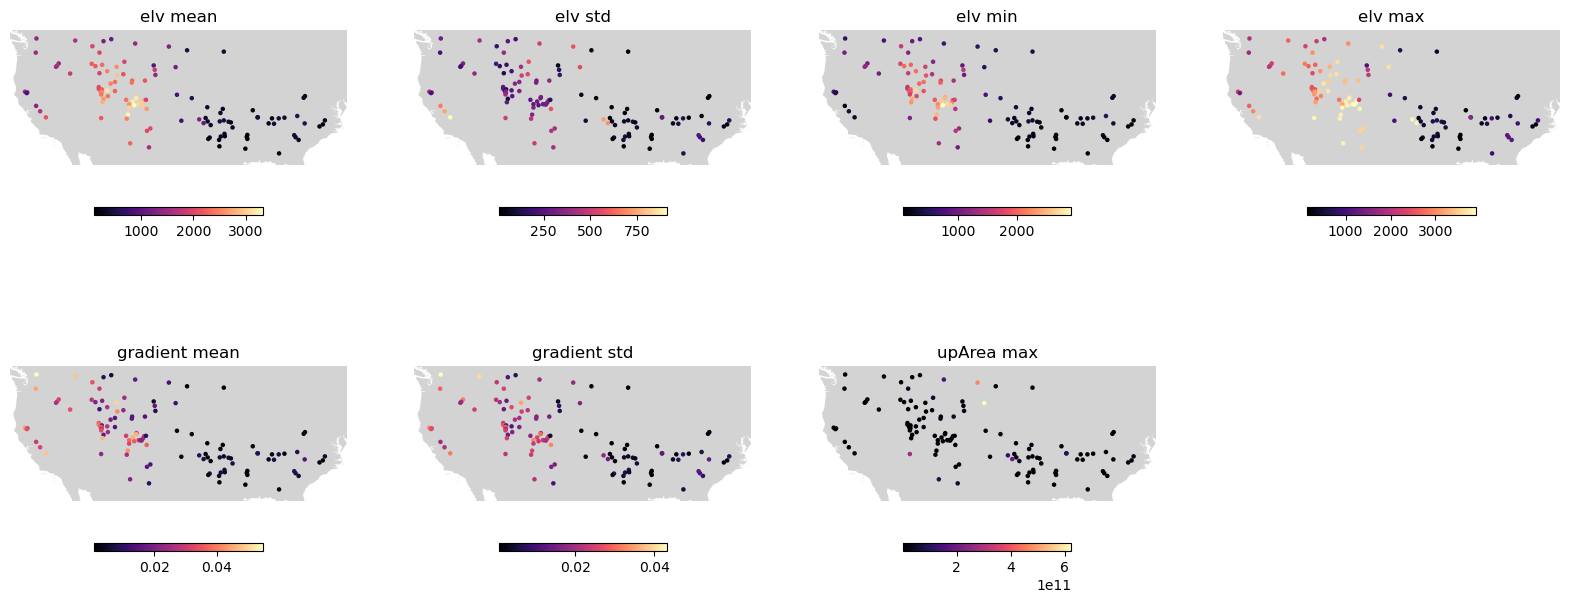

In [6]:
category = 'geomorphology'

if category in cfg['static_maps']:
    
    subfolder = cfg['static_maps'][category]['subfolder']
    func = cfg['static_maps'][category]['statistics']
    band = cfg['static_maps'][category].get('band', 'Band1')

    if isinstance(func, dict):
        variables = list(func)
        statistic = list({stat for stats in func.values() for stat in stats})
        cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
    elif isinstance(func, list):
        variables = {file.stem.split('_')[0] for file in (PATH_MAPS / subfolder).glob('*.nc')}
        statistic = func
        cols = None
    
    # load maps
    maps = xr.Dataset({var: xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/{var}_*.nc')[band].compute() for var in func})

    # compute statistics
    attrs = catchment_statistics(maps, masks, statistic=statistic, weight=pixarea).to_pandas()
    if cols is not None:
        attrs = attrs[cols]

    # plot attributes
    plot_attributes(attrs,
                    catchments.geometry.x,
                    catchments.geometry.y,
                    ncols=4,
                    extent=extent,
                    save=PATH_PLOTS / f'maps_{category}.jpg')
    
    attributes[category] = attrs
    del maps

### Land use

Time elapsed: 11.20 seconds


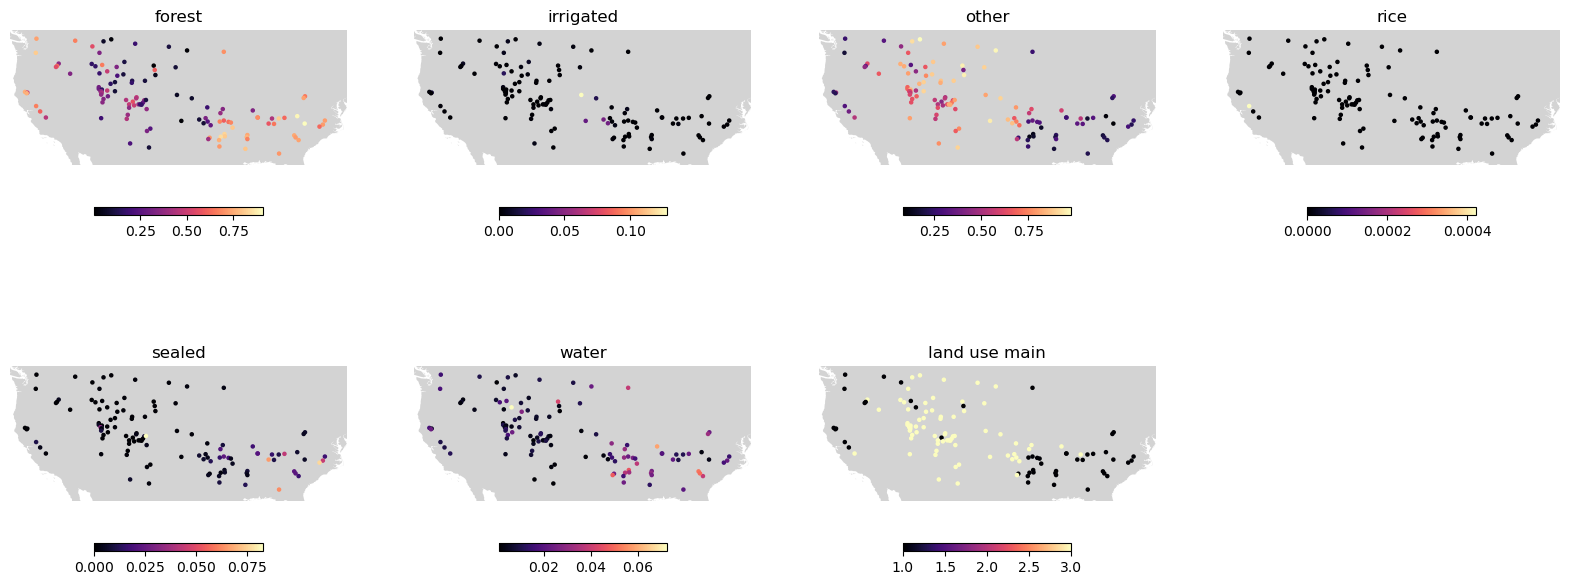

In [7]:
category = 'land_use'

if category in cfg['static_maps']:
    
    subfolder = cfg['static_maps'][category]['subfolder']
    func = cfg['static_maps'][category]['statistics']
    band = cfg['static_maps'][category].get('band', 'Band1')   

    if isinstance(func, dict):
        variables = list(func)
        statistic = list({stat for stats in func.values() for stat in stats})
        cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
    elif isinstance(func, list):
        variables = {file.stem.split('_')[0] for file in (PATH_MAPS / subfolder).glob('frac*.nc')}
        statistic = func
        cols = None

    # load maps
    land_use = xr.Dataset({var: xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/{var}_*.nc')[band].compute() for var in variables})
    land_use = land_use.rename({var: var[4:] for var in list(land_use)})

    # compute statistics
    attr_landuse = catchment_statistics(land_use, masks, statistic=statistic, weight=pixarea).to_pandas()
    attr_landuse.sort_index(axis=1, inplace=True)

    # compute main land use
    lu_classes = {col: i for i, col in enumerate(attr_landuse.columns, start=1)}
    attr_landuse['land_use_main'] = attr_landuse.idxmax(axis=1).map(lu_classes)

    # rename attributes
    attr_landuse.rename(columns={col: col.split('_')[0] if 'mean' in col else col for col in attr_landuse}, inplace=True)

    # plot attributes
    plot_attributes(attr_landuse,
                    catchments.geometry.x,
                    catchments.geometry.y,
                    ncols=4,
                    extent=extent,
                    save='maps_land_use.jpg')
    
    attributes[category] = attr_landuse

### Crop coefficient

In [8]:
category = 'crops'

# mapping land use acronym and name
mapping_landuse = {'f': 'forest', 'i': 'irrigated', 'o': 'other'}

if category in cfg['static_maps']:
    
    subfolder = cfg['static_maps'][category]['subfolder']
    func = cfg['static_maps'][category]['statistics']
    band = cfg['static_maps'][category].get('band', 'Band1')  

    if isinstance(func, dict):
        variables = list(func)
        statistic = list({stat for stats in func.values() for stat in stats})
        cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
    elif isinstance(func, list):
        variables = {file.stem.split('_')[0] for file in (PATH_MAPS / subfolder).glob('frac*.nc')}
        statistic = func
        cols = None

    # load maps
    maps = xr.Dataset({var: xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/{var}_*.nc')[band].compute() for var in variables})
    maps = maps.rename({var: mapping_landuse[var.split('_')[1]] for var in list(maps)})

    # mean weighted by the fraction of pixel covered by each land use
    maps = maps.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
    maps = maps.where(~upArea.isnull())
    maps.name = 'cropcoef'

    # compute statistics
    attrs = catchment_statistics(maps, masks, statistic=statistic, weight=pixarea).to_pandas()

    # plot attributes
    plot_attributes(attrs,
                    catchments.geometry.x,
                    catchments.geometry.y,
                    ncols=2,
                    extent=extent,
                    save=PATH_PLOTS / f'maps_{category}.jpg')

    attributes[category] = attrs
    del maps

### Streams

Time elapsed: 11.69 seconds


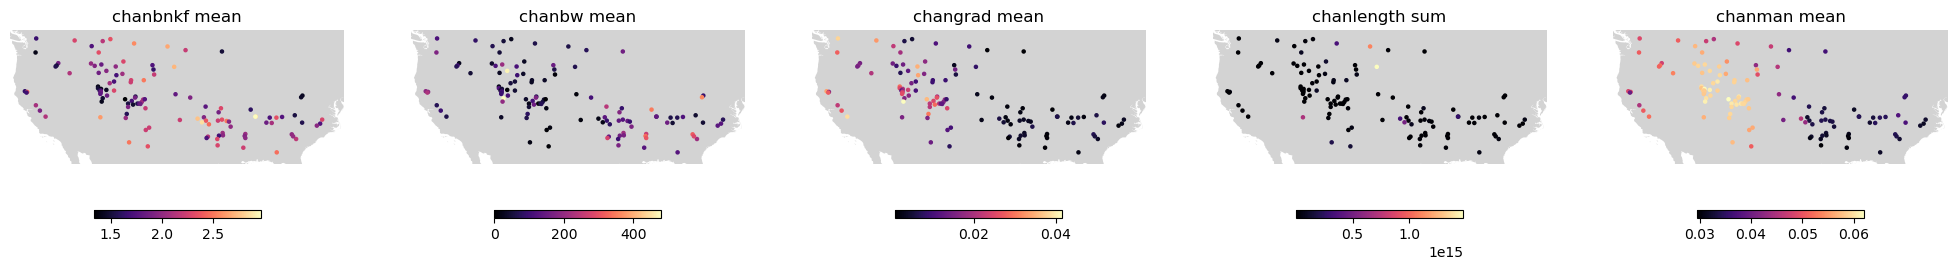

In [ ]:
category = 'streams'

if category in cfg['static_maps']:
    
    subfolder = cfg['static_maps'][category]['subfolder']
    func = cfg['static_maps'][category]['statistics']
    band = cfg['static_maps'][category].get('band', 'Band1')

    if isinstance(func, dict):
        variables = list(func)
        statistic = list({stat for stats in func.values() for stat in stats})
        cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
    elif isinstance(func, list):
        variables = {file.stem.split('_')[0] for file in (PATH_MAPS / subfolder).glob('*.nc')}
        statistic = func
        cols = None

    # load maps
    maps = {var: xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/{var}_*.nc')[band].compute() for var in variables}
    maps = {var: da.rename(var) for var, da in maps.items()}
    maps = {var : da.drop([coord for coord in list(da.coords) if coord not in ['lon', 'lat']]) for var, da in maps.items()}
    maps = xr.Dataset({var: xr.DataArray(da.data, coords=upArea.coords, name=var) for var, da in maps.items()})

    # mask streams (pixels with depth larger than 1 m)
    rivers = maps['chanbnkf'] > 1
    maps = maps.where(rivers)

    # compute statistics
    attrs = catchment_statistics(maps, masks, statistic, weight=pixarea).to_pandas()
    if cols is not None:
        attrs = attrs[cols]

    # plot attributes
    plot_attributes(attrs,
                    catchments.geometry.x,
                    catchments.geometry.y,
                    ncols=5,
                    extent=extent,
                    save=PATH_PLOTS / f'maps_{category}.jpg')
    
    attributes[category] = attrs
    del maps

### Soil properties

loading maps:   0%|          | 0/18 [00:00<?, ?it/s]

Time elapsed: 98.08 seconds


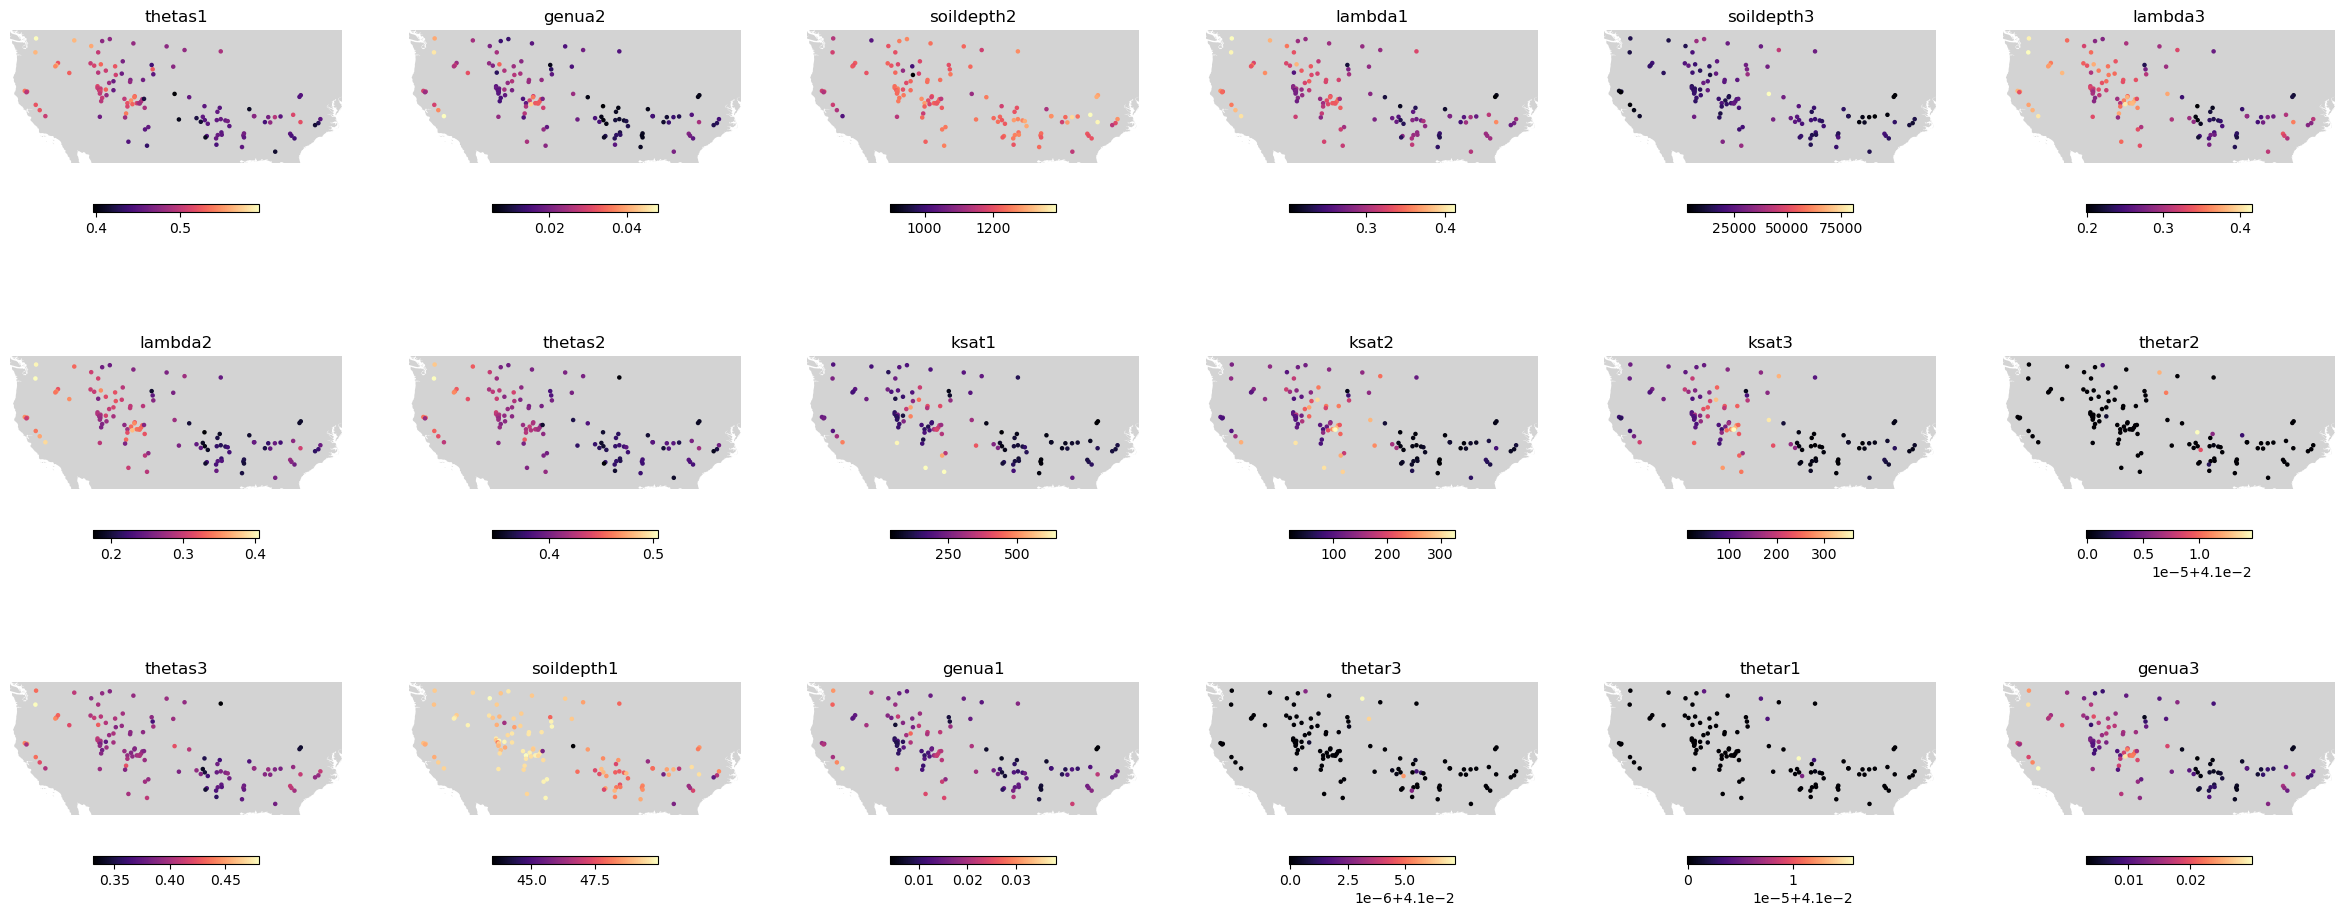

In [29]:
category = 'soils'

if category in cfg['static_maps']:
    
    subfolder = cfg['static_maps'][category]['subfolder']
    func = cfg['static_maps'][category]['statistics']
    band = cfg['static_maps'][category].get('band', 'Band1')

    if isinstance(func, dict):
        variables = list(func)
        statistic = list({stat for stats in func.values() for stat in stats})
        cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
    elif isinstance(func, list):
        variables = {file.stem.split('_')[0] for file in (PATH_MAPS / subfolder).glob('*.nc')}
        statistic = func
        cols = None

    # load maps
    maps = {}
    for var in tqdm(variables, desc='loading maps'):
        files = list((PATH_MAPS / subfolder).glob(f'{var}_*.nc'))
        if len(files) > 1:
            ds = {}
            for file in files:
                # type of land use
                cover = mapping_landuse[file.stem.split('_')[1]]
                # import map
                ds[cover] = xr.open_dataset(file)[band]
            ds = xr.Dataset(ds)
            da = ds.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True)
            maps[var] = da.where(~upArea.isnull())
        elif len(files) == 1:
            maps[var] = xr.open_dataset(files[0])[band]
    maps = xr.Dataset(maps)

    # compute statistics
    attrs = catchment_statistics(maps, masks, statistic=statistic, weight=pixarea).to_pandas()

    # rename attributes
    attrs.rename(columns={col: col.split('_')[0] for col in attrs if 'mean' in col}, inplace=True)

    # plot attributes
    plot_attributes(attrs,
                    catchments.geometry.x,
                    catchments.geometry.y,
                    ncols=6,
                    extent=extent,
                    save=PATH_PLOTS / f'maps_{category}.jpg')
    
    attributes[category] = attrs
    del maps

### LAI

I convert the timeseries of 10-daily timesteps into annual and monthly averages.

Time elapsed: 62.61 seconds


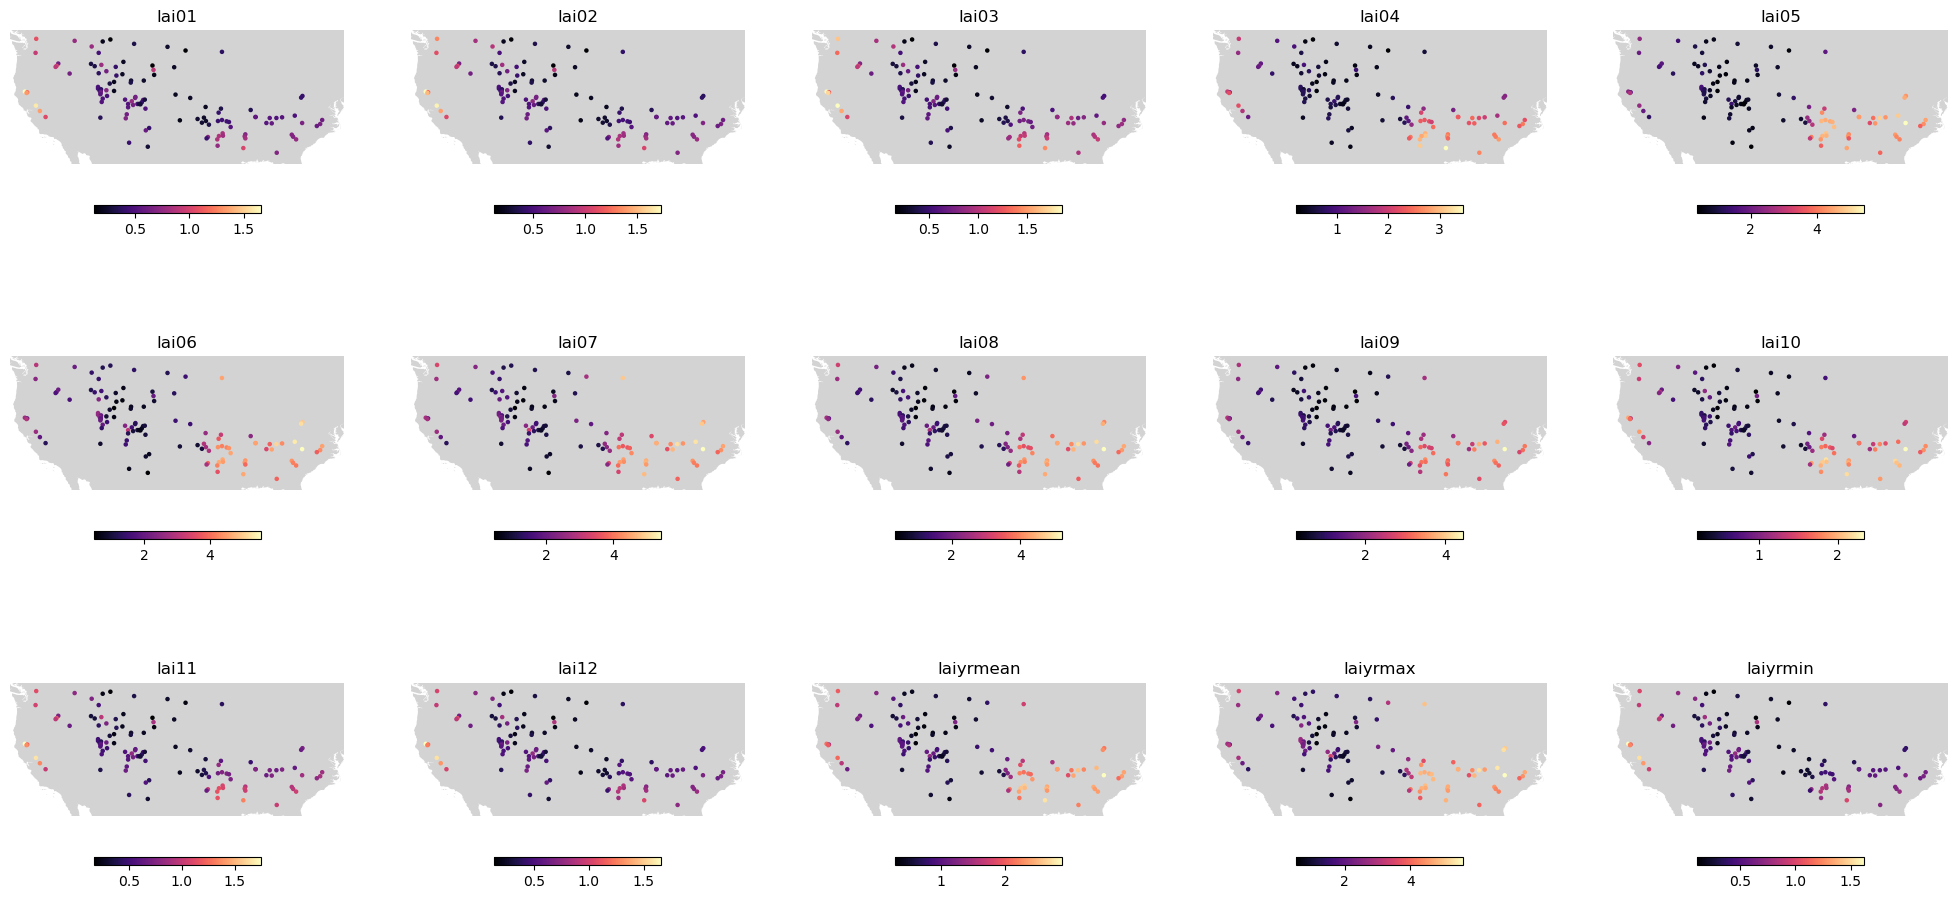

In [21]:
category = 'lai'

if category in cfg['static_maps']:
    
    subfolder = cfg['static_maps'][category]['subfolder']
    func = cfg['static_maps'][category]['statistics']
    band = cfg['static_maps'][category].get('band', 'Band1')

    if isinstance(func, dict):
        variables = list(func)
        statistic = list({stat for stats in func.values() for stat in stats})
        cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
    elif isinstance(func, list):
        variables = {file.stem.split('_')[0] for file in (PATH_MAPS / subfolder).glob('*.nc')}
        statistic = func
        cols = None

    # load maps
    lai = xr.Dataset({var: xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/{var}*.nc')[band].compute() for var in variables})
    lai = lai.rename({var: mapping_landuse[var[3]] for var in list(lai)})

    # mean wheighted by the portion of pixel covered by each land use
    lai = lai.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
    lai = lai.where(~upArea.isnull())
    lai.name = 'lai'
    lai['time'] = pd.date_range('2021-01-05', periods=len(lai.time), freq='10D')

    # monthly resampling
    lai_m = lai.resample(time='1M').mean()
    lai_m['time'] = [f'{i:02}' for i in range(1, 13)]
    lai_agg = xr.Dataset({f'lai{month}': lai_m.sel(time=month).drop('time') for month in lai_m.time.data})

    # annual statistics
    lai_agg['laiyrmean'] = lai.mean('time')
    lai_agg['laiyrmax'] = lai.max('time')
    lai_agg['laiyrmin'] = lai.min('time')

    # compute statistics
    attrs = catchment_statistics(lai_agg, masks, statistic=statistic, weight=pixarea).to_pandas()

    # rename attributes
    attrs.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attrs if 'mean' in col}, inplace=True)

    # plot attributes
    plot_attributes(attrs,
                    catchments.geometry.x,
                    catchments.geometry.y,
                    ncols=5,
                    extent=extent,
                    save=PATH_PLOTS / f'maps_{category}.jpg')
    
    attributes[category] = attrs
    del lai, lai_agg

### Water demand

The original demand maps are monthly time series (domestic, energy, industry, livestock) in mm/day for the period 1990-2023. 

I will compute annual and monthly averages and from those I will compute statistics.

In [22]:
category = 'water_demand'

if category in cfg['static_maps']:
    
    subfolder = cfg['static_maps'][category]['subfolder']
    func = cfg['static_maps'][category]['statistics']
    band = cfg['static_maps'][category].get('band', 'Band1')

    if isinstance(func, dict):
        variables = list(func)
        statistic = list({stat for stats in func.values() for stat in stats})
        cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
    elif isinstance(func, list):
        variables = {file.stem.split('_')[0] for file in (PATH_MAPS / subfolder).glob('*.nc')}
        statistic = func
        cols = None

    # load maps
    demand = {}
    start, end = pd.to_datetime('1979-01-02'), pd.to_datetime('2023-01-01')
    dates = pd.date_range(start, end, freq='D')
    for use in tqdm(variables):

        # load dataset of demand
        da = xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/{use}*.nc')[use]

        # compute cachtment statistic
        df = catchment_statistics(da, masks, statistic=statistic, weight=pixarea)[f'{use}_mean'].to_pandas()

        # convert dataframe to daily resolution
        daily_df = pd.DataFrame(np.nan, index=dates, columns=df.columns)
        daily_df.index.name = 'time'
        daily_df.loc[df.index] = df

        # fill NaN
        daily_df = daily_df.ffill()
        # daily_df = daily_df.interpolate(method='linear')

        # convert to DataArray
        demand[use] = xr.Dataset.from_dataframe(daily_df).to_array(dim='id', name=use)

    # combine all demands in one Dataset
    demand = xr.Dataset(demand)

    # monthly means
    demand_m = demand.groupby('time.month').mean('time')

    # annual mean
    demand_y = demand.groupby('time.year').mean('time').mean('year')
    # demand_y = demand.mean('time')

    # combine in a single dataset
    demand_agg = xr.Dataset()
    for key, da in demand_m.items():
        for month in da.month.data:
            demand_agg[f'{key}_{month:02}'] = da.sel(month=month).drop('month')
        demand_agg[f'{key}_yr'] = demand_y[key]

    # convert to volume
    # demand_agg = demand_agg * 1e-3 * pixarea

    # # compute statistics
    # attrs = catchment_statistics(demand_agg, masks, statistic=['sum'], weight=pixarea).to_pandas()

    # # rename attributes
    # attrs.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attrs if 'sum' in col}, inplace=True)

    attrs = demand_agg.to_pandas()

    # plot attributes
    plot_attributes(attrs[['dom_yr', 'ene_yr', 'ind_yr', 'liv_yr']],
                    catchments.geometry.x,
                    catchments.geometry.y,
                    ncols=4,
                    extent=extent,
                    save=PATH_PLOTS / f'maps_{category}.jpg'
                   )
    
    attributes[category] = attrs
    del demand

### Reservoirs

In [25]:
category = 'reservoirs'

if category in cfg['static_maps']:
        
    subfolder = cfg['static_maps'][category]['subfolder']
    func = cfg['static_maps'][category]['statistics']
    band = cfg['static_maps'][category].get('band', 'Band1')

    if isinstance(func, dict):
        variables = list(func)
        statistic = list({stat for stats in func.values() for stat in stats})
        cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
    elif isinstance(func, list):
        variables = {file.stem.split('_')[0] for file in (PATH_MAPS / subfolder).glob('*.nc')}
        statistic = func
        cols = None

    # load map of reservoir ID
    if len(variables) == 1:
        maps = xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/*{variables[0]}*.nc')[band].compute()
    elif len(variables) > 1:
        maps =xr.Dataset({var: xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/*{var}*.nc')[band].compute() for var in variables})

    # extract reservoir ID
    ids = [int(id) for id in np.unique(maps) if (not np.isnan(id))]
    ids = [id for id in ids if id >= 0]
    print('{0} reservoirs in the study area'.format(len(ids)))

    # load table of total reservoir storage
    file = list((PATH_MAPS / subfolder).glob('rstor*.txt'))[0]
    storage_pd = pd.read_csv(file, sep='\t', header=None, index_col=0).squeeze().astype('int64')
    storage_pd.index.name = 'ResID'
    storage_pd.name = 'storage'

    # create map of reservoir storage
    storage = maps.copy(deep=True)
    for id in ids:
        storage = storage.where(maps != id, other=storage_pd.loc[id])
    # storage /= 1e6
    storage.name = 'storage'
    storage.attrs['units'] = 'm3'
    storage.attrs['standard_name'] = 'capacity'
    storage.attrs['long_name'] = 'reservoir_storage_capacity'

    # compute statistics
    attrs = catchment_statistics(storage, masks, statistic=['count', 'sum']).to_pandas()

    # rename attributes
    attrs.rename(columns={'storage_count': 'no_reservoirs', 'storage_sum': 'storage_reservoirs'}, inplace=True)

    # plot attributes
    plot_attributes(attrs,
                    catchments.geometry.x,
                    catchments.geometry.y,
                    extent=extent,
                    save=PATH_PLOTS / f'maps_{category}.jpg')
    
    attributes[category] = attrs
    del maps, storage

### Lakes

In [23]:
category = 'lakes'

if category in cfg['static_maps']:

    subfolder = cfg['static_maps'][category]['subfolder']
    func = cfg['static_maps'][category]['statistics']
    band = cfg['static_maps'][category].get('band', 'Band1')

    if isinstance(func, dict):
        variables = list(func)
        statistic = list({stat for stats in func.values() for stat in stats})
        cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
    elif isinstance(func, list):
        variables = {file.stem.split('_')[0] for file in (PATH_MAPS / subfolder).glob('*.nc')}
        statistic = func
        cols = None

    # load map or lake ID  
    if len(variables) == 1:
        maps = xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/*{variables[0]}*.nc')[band].compute()
    elif len(variables) > 1:
        maps =xr.Dataset({var: xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/*{var}*.nc')[band].compute() for var in variables})
        
    # extract lake ID
    ids = [int(id) for id in np.unique(maps) if not np.isnan(id)]
    ids = [id for id in ids if id >= 0]
    print('{0} lakes in the study area'.format(len(ids)))

    # load table of lake area
    file = list((PATH_MAPS / subfolder).glob('lakearea*.txt'))[0]
    lakes_pd = pd.read_csv(file, sep='\t', header=None, index_col=0).squeeze().astype('int64')
    lakes_pd.index.name = 'LakeID'
    lakes_pd.name = 'area'

    # create map of lake area
    lakearea = maps.copy(deep=True)
    for id in ids:
        lakearea = lakearea.where(maps != id, other=lakes_pd.loc[id])
    lakearea.name = 'area'
    lakearea.attrs['units'] = 'm2'
    lakearea.attrs['standard_name'] = 'area'
    lakearea.attrs['long_name'] = 'lake_surface_area'

    # compute statistics
    attrs = catchment_statistics(lakearea, masks, statistic=['count', 'sum']).to_pandas()

    # rename attributes
    attrs.rename(columns={'area_count': 'no_lakes', 'area_sum': 'area_lakes'}, inplace=True)

    # plot attributes
    plot_attributes(attrs, 
                    catchments.geometry.x, 
                    catchments.geometry.y, 
                    extent=extent, 
                    save=PATH_PLOTS / f'maps_{category}.jpg'
                   )
    
    attributes[category] = attrs
    del maps, lakearea

### Export

In [31]:
# concatenate all attributes
attributes = pd.concat([attrs for category, attrs in attributes.items()], axis=1)
attributes.index.name = ID_OUT
attributes.sort_index(axis=0, inplace=True)

print('{0} attributes define the characteristics of {1} catchments'.format(*attributes.shape[::-1]))

# export
attributes.to_csv(PATH_OUT / 'glofas_static_maps.csv')

54 attributes define the characteristics of 119 catchments


## Model parameters
### Statistic

Time elapsed: 57.91 seconds
14 attributes define the model parameters of 119 catchments


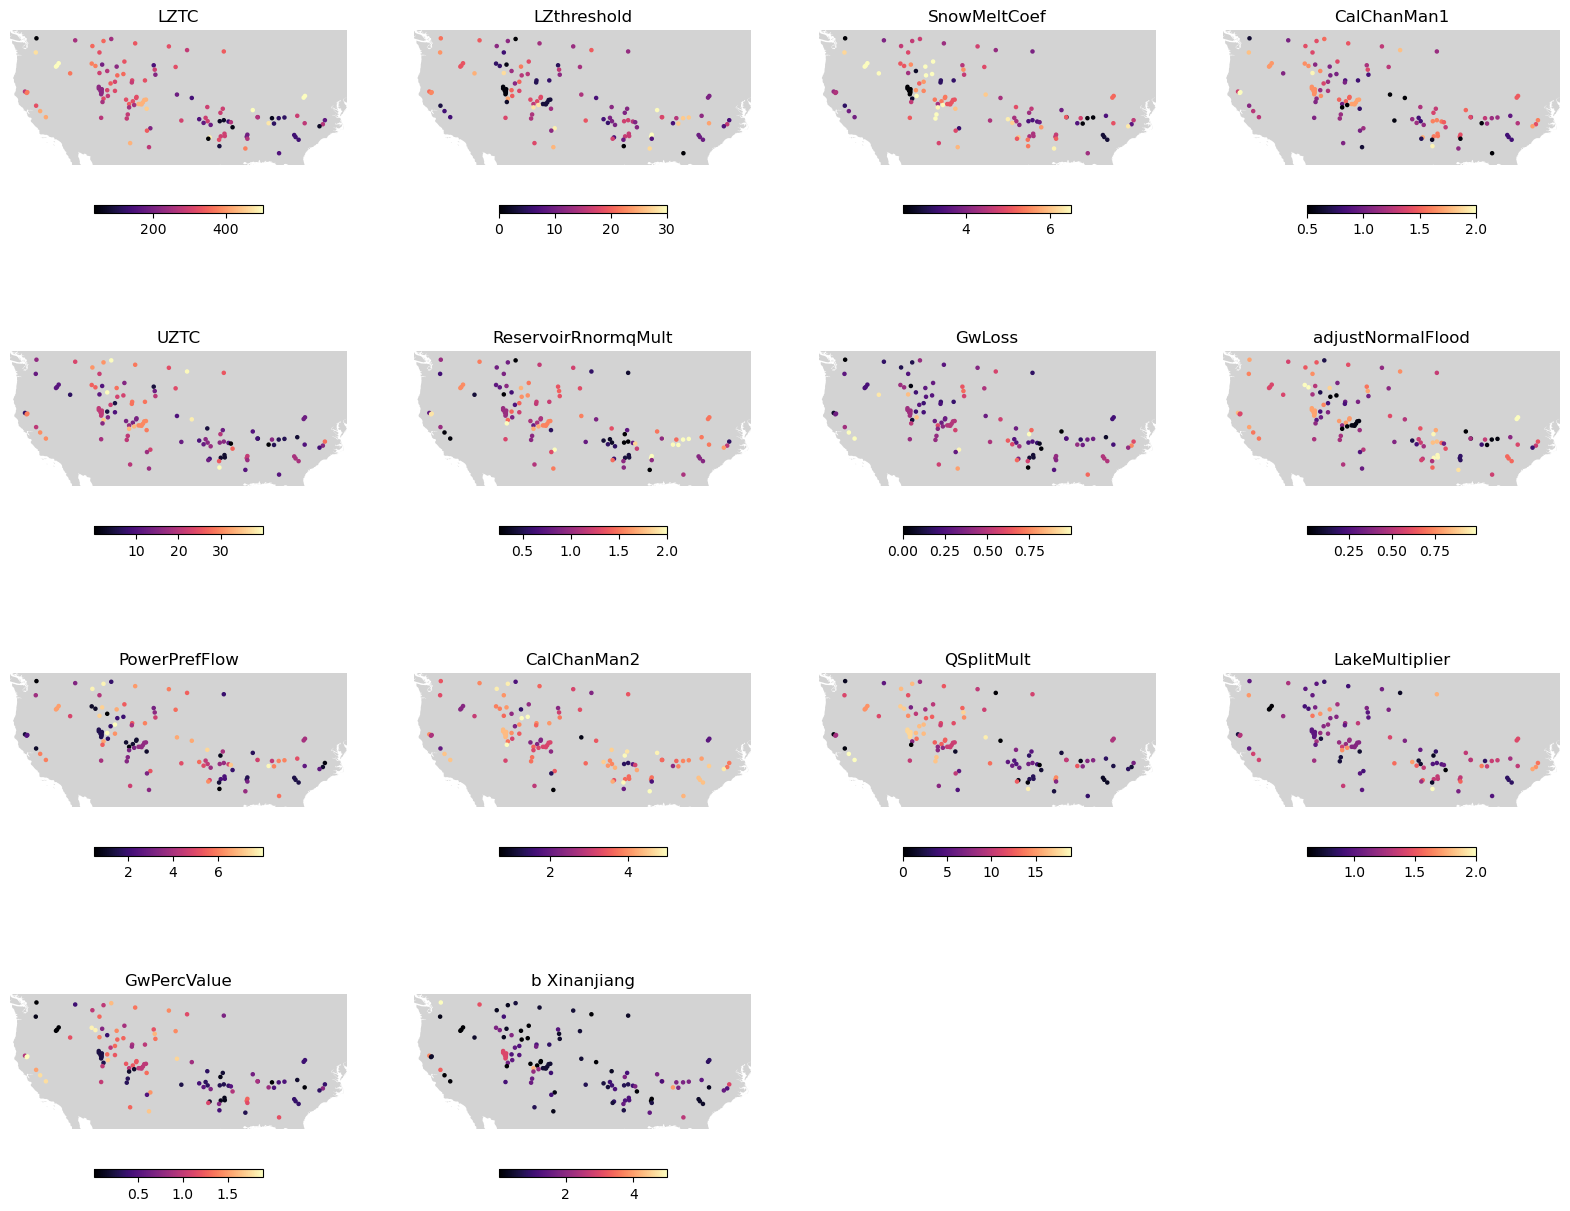

In [42]:
category = 'parameters'

if category in cfg['static_maps']:

    subfolder = cfg['static_maps'][category]['subfolder']
    func = cfg['static_maps'][category]['statistics']
    band = cfg['static_maps'][category].get('band', 'Band1')

    if isinstance(func, dict):
        variables = list(func)
        statistic = list({stat for stats in func.values() for stat in stats})
        cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
    elif isinstance(func, list):
        variables = {file.stem.split('_GloFAS')[0] for file in (PATH_MAPS / subfolder).glob('*.nc')}
        statistic = func
        cols = None

    # load maps
    maps = {}
    for var in variables:
        da = xr.open_mfdataset(f'{PATH_MAPS}/{subfolder}/{var}*.nc')[var].compute()
        if da.dtype == '<m8[ns]':
            da = da.astype(float) / (1e9 * 3600 * 24)
        maps[var] = da
    maps = xr.Dataset(maps)
    maps = maps.where(maps != -9999, np.nan)

    # compute statistics
    parameters = catchment_statistics(maps, masks, statistic=statistic, weight=pixarea).to_pandas()
    parameters.columns = ['_'.join(col.split('_')[:-1]) for col in parameters.columns]

    # plot attributes
    plot_attributes(parameters,
                    catchments.geometry.x,
                    catchments.geometry.y,
                    ncols=4,
                    extent=extent,
                    save=PATH_PLOTS / f'maps_{category}.jpg')

    del maps

    # export
    parameters.index.name = ID_OUT
    parameters.sort_index(axis=0, inplace=True)
    print('{0} attributes define the model parameters of {1} catchments'.format(*parameters.shape[::-1]))
    parameters.to_csv(PATH_OUT / 'glofas_model_parameters.csv')